# Demos and Cool Stuff

#### Quentin CAUDRON  <br /> <br />  Ecology and Evolutionary Biology <br /> <br />  qcaudron@princeton.edu <br /> <br />  @QuentinCAUDRON

In [39]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats as st
import scipy.spatial as sp
import scipy.ndimage as nd
import scikits.bootstrap as bootstrap
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import lmfit as lm
import pymc
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import datasets, svm
from sklearn.cross_validation import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from skimage import io, morphology, exposure, filter, feature, color, measure
import pickle
import seaborn
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (14, 5)
seaborn.set_style("darkgrid")

### LMFit : Nonlinear, Constrained Minimisation

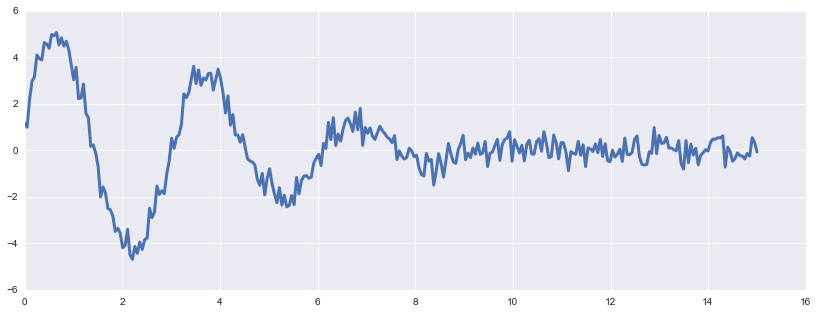

In [40]:
# http://lmfit.github.io/lmfit-py/parameters.html#simple-example

# Let's create a damped sinusoid
# True function :
# 5 sin(2x + 0.3) * exp(-0.03*(x^2))

x = np.linspace(0, 15, 300)
y = 5 * np.sin(2 * x + 0.3) * np.exp(-0.03 * (x**2)) + np.random.normal(size=len(x), scale=0.4)
plt.plot(x, y, lw=3)

[[Variables]]
    amplitude:   4.95635822 +/- 0.103865 (2.10%) (init= 10)
    phase:       0.26595648 +/- 0.022663 (8.52%) (init= 0)
    frequency:   2.01179254 +/- 0.007891 (0.39%) (init= 1)
    decay:      -0.02923388 +/- 0.006653 (22.76%) (init=-0.1)
    power:       2.03717876 +/- 0.118614 (5.82%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(decay, power)              =  0.987 
    C(phase, frequency)          = -0.808 
    C(amplitude, decay)          = -0.720 
    C(amplitude, power)          = -0.660 
    C(amplitude, phase)          = -0.184 
    C(amplitude, frequency)      =  0.152 
    C(phase, decay)              =  0.138 
    C(phase, power)              =  0.127 
    C(frequency, decay)          = -0.114 
    C(frequency, power)          = -0.105 


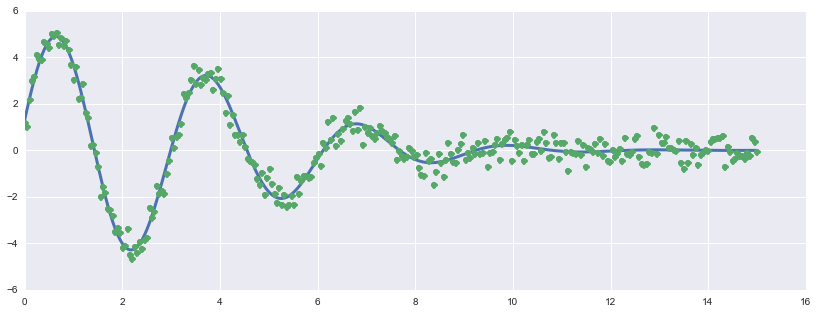

In [41]:
# We can use lmfit to fit this function to a model
def objectivefunction(params, x, data) :
    amplitude = params["amplitude"].value
    phase = params["phase"].value
    frequency = params["frequency"].value
    decay = params["decay"].value
    power = params["power"].value
    
    model = amplitude * np.sin(frequency * x + phase) * np.exp(decay * (x**power))
    return model - data


# We create a parameters structure
params = lm.Parameters()
params.add("amplitude", value=10, min=0)
params.add("phase", value=0, min=-np.pi, max=np.pi)
params.add("frequency", value=1)
params.add("decay", value=-0.1, max=-0.01)
params.add("power", value=1, min=0.5)

# Fit the function
result = lm.minimize(objectivefunction, params, args = (x, y))

plt.plot(x, y + result.residual, linewidth=3)
plt.plot(x, y, "o")

lm.report_fit(params)

### PyMC : MCMC with No U-Turn Sampler

I write a number of lines of code every day. It's probably Poisson-distributed.

- c : **c**hocolate covered coffee beans help me write faster when I have some
- b : I get **b**etter at writing efficiently over time, linearly ( writing less )
- s : my typing **s**peed improves logarithmically with time
- u : I have an **u**nderlying rate at which I write

So, I write **y** lines of code per day, where 

$y \,\sim\, \mathrm{Poi}(u + c - b\,t + s\,\log(t))$

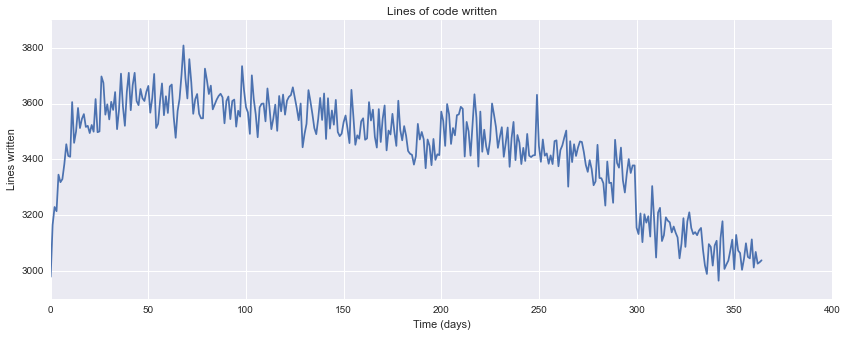

In [42]:
# Time
t = np.arange(1, 366) # one year

# True parameters
u = 3000
s = 200
b = 3.14
c = 123

# When do I have coffee beans ?
have_coffeebeans = np.zeros(365)
have_coffeebeans[200:300] = 1

# Generate observations
y = np.random.poisson(u - b * t + c * have_coffeebeans + s * np.log(t))

plt.plot(y)
plt.title("Lines of code written")
plt.xlabel("Time (days)")
plt.ylabel("Lines written")

In [43]:
with pymc.Model() as model :
    background = pymc.Normal("background u", 3100, sd=100)
    speed = pymc.Uniform("typing speed s", 100, 300)
    efficiency = pymc.Uniform("better coding b", 1, 10)
    coffeeboost = pymc.Normal("caffeine boost c", 90, sd=20)
    
    lines = pymc.Poisson("lines written y", background
                                             + coffeeboost * have_coffeebeans
                                             - efficiency * t
                                             + speed * pymc.log(t), observed=y)
                                             
    start = pymc.find_MAP()
    step = pymc.NUTS()
    trace = pymc.sample(50000, step, start)

 [-----------------100%-----------------] 50000 of 50000 complete in 328.6 sec

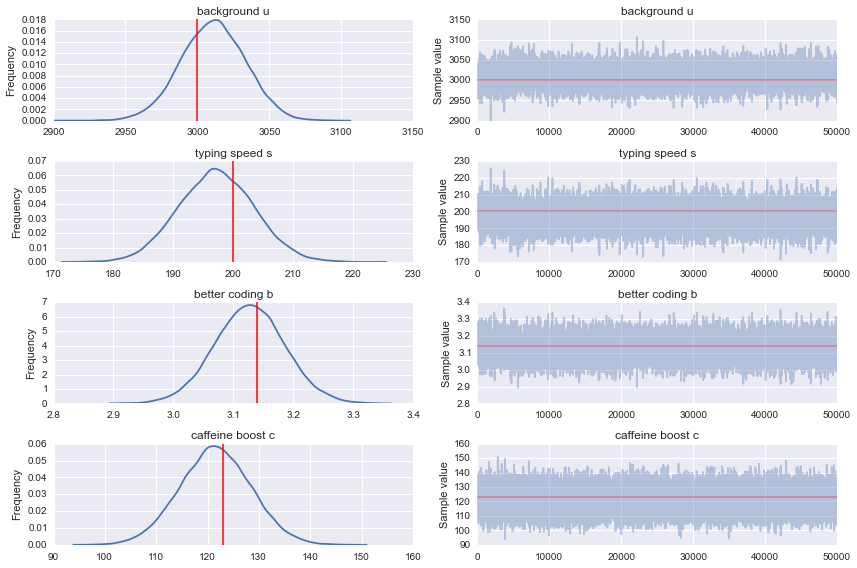

In [44]:
pymc.traceplot(trace, lines={"background u" : u,
                             "typing speed s" : s,
                             "better coding b" : b,
                             "caffeine boost c" : c});

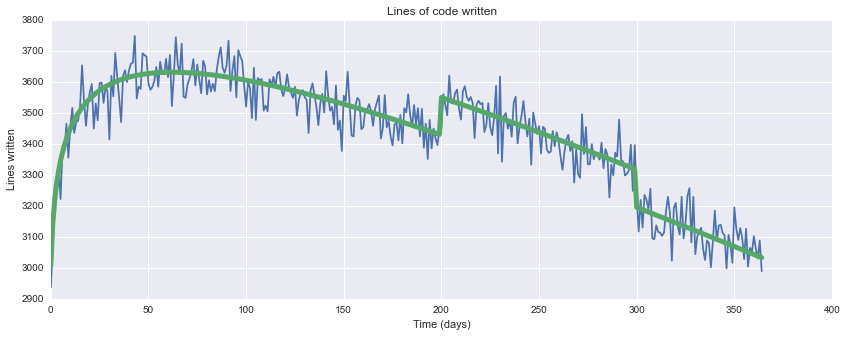

In [49]:
yhat = (trace["background u"].mean()
        - trace["better coding b"].mean() * t
        + trace["caffeine boost c"].mean() * have_coffeebeans
        + trace["typing speed s"].mean() * np.log(t))

plt.plot(y)
plt.plot(yhat, lw=5)
plt.title("Lines of code written")
plt.xlabel("Time (days)")
plt.ylabel("Lines written")

### Pickle - Saving Python Objects to Disk

In [26]:
# Create a dictionary of random objects
x = { "Species": "Homo sapiens", "Age": 73, "Foods" : ["Chocolate", "Coffee", "Waffles"] }

# Let's save this arbitrary object to file
pickle.dump(x, open("pickled_human.p", "w"))

# Now let's read it back in
human = pickle.load(open("pickled_human.p", "r"))

# We can access it as normal
print human["Foods"]

['Chocolate', 'Coffee', 'Waffles']


### Scikit-Learn : Machine Learning

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


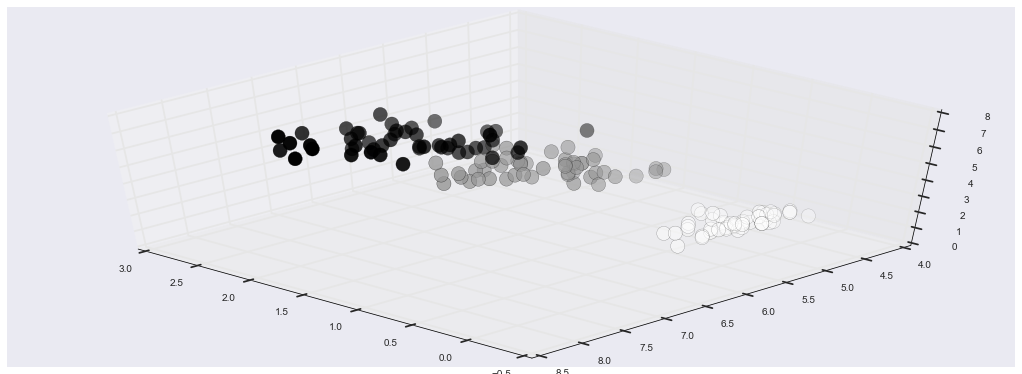

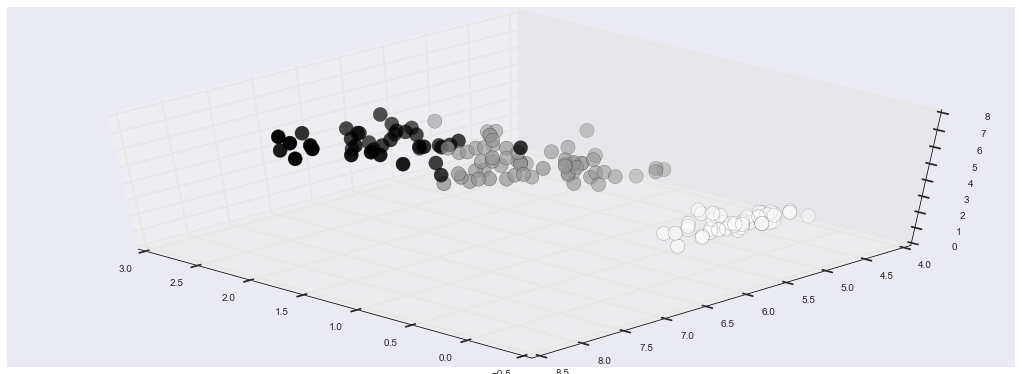

In [27]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html
# K-Means Clustering

# Let's load the Iris database
iris = datasets.load_iris()
X = iris.data # first two features only
y = iris.target # classes

# First five measurements, and all of the classes
print X[:5, :], "\n"
print y

kmeans = KMeans(n_clusters=len(np.unique(y)))
kmeans.fit(X, y)


fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, s=200)

fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=kmeans.predict(X), s=200)

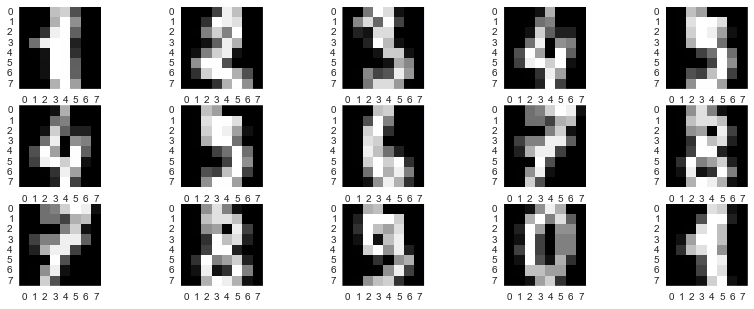

In [28]:
# http://scikit-learn.org/stable/tutorial/basic/tutorial.html#introduction
# SVC

# Let's load the digits database
digits = datasets.load_digits()

# What do these digits look like ?
for i in range(1, 6) :
    for j in range(3) :
        plt.subplot(3, 5, j*5 + i)
        plt.imshow(digits.images[j*3 + i], cmap="gray", interpolation="none")
        plt.grid(b=False)

In [29]:
# I want to run some error analysis
# We're going to split the dataset into a variable number of train and test samples
# and from there, we'll see how the mean error changes with the train / test fraction

Success = [] # empty list
fraction = np.exp(np.linspace(np.log(0.001), np.log(0.5), 30)) # the fraction of the dataset to reserve for testing

for i in fraction :

    success = [] # empty list to keep our measurements for a given fraction
    
    for j in range(20) : # twenty random repetitions
        # Let's split the dataset randomly
        traindata, testdata, traintarget, testtarget = train_test_split(digits.data, digits.target, test_size=i)

        # Fit the classifier
        classifier = svm.SVC()
        classifier.fit(traindata, traintarget)

        # Calculate success rate
        success.append(np.sum(classifier.predict(testdata) == testtarget) / float(len(testtarget)))
    
    # Append all twenty measurements to our list 
    Success.append(success)
    # Do not run this cell unless you're happy to wait a little while

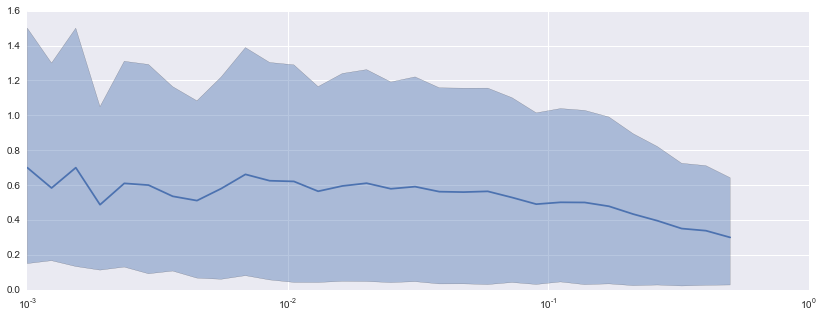

In [30]:
# OK, let's plot our results. First, let's calculate the mean success rate
meansuccess = np.mean(Success, axis=1)

# And bootstrap some confidence intervals
confint = [bootstrap.ci(np.array(Success)[i, :]) for i in range(len(meansuccess))]

# Drop our CIs around the plot
CIdown = [meansuccess[i] - confint[i][0] for i in range(len(meansuccess))]
CIup = [meansuccess[i] + confint[i][1] for i in range(len(meansuccess))]

# And plot
plt.semilogx(fraction, meansuccess)
plt.fill_between(fraction, CIdown, y2=CIup, alpha=0.4)

### Scikit-Image : Image Processing

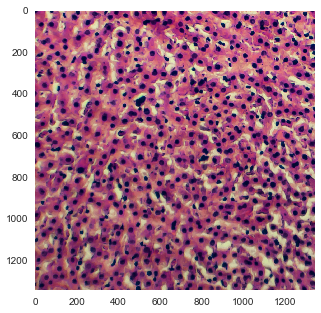

In [31]:
# Let's open up an RGB histological image of a slice of liver
img = io.imread("liver.jpg")
io.imshow(img)
plt.grid(b=False)

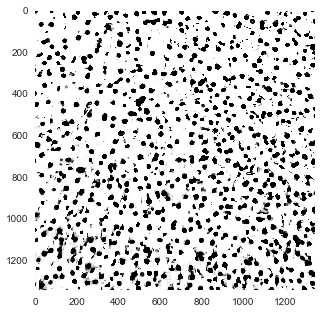

In [32]:
# We'll begin by sigmoid transforming the red channel, to enhance contrast
A = exposure.adjust_sigmoid(img[:, :, 0], cutoff=0.4, gain=30)
io.imshow(A)
plt.grid(b = False)

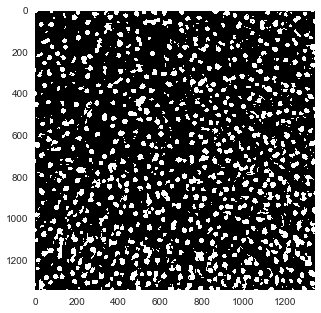

In [33]:
# Let's threshold the image, based on the Otsu value
# We'll also invert the image in the process, to keep with image processing tradition :
# "Foreground" elements are 1, and background is 0
B = A < filter.threshold_otsu(A)
io.imshow(B)
plt.grid(b = False)

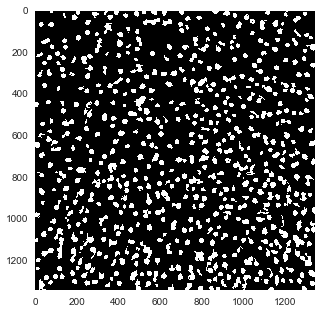

In [34]:
# We have some noise. Let's remove small components :
C = morphology.remove_small_objects(B, 200)
io.imshow(C)
plt.grid(b = False)

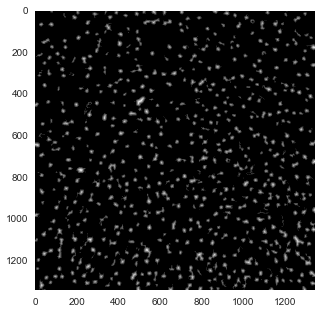

In [35]:
# Some of the nuclei are touching, and hence, segmenting based on objects won't give a good answer.
# We'll apply a smoothed distance transform first...
D = nd.distance_transform_edt(C)
io.imshow(D)
plt.grid(b = False)

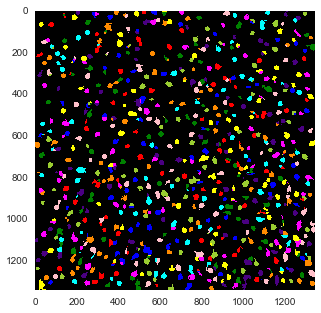

In [36]:
# ... and throw in a watershed algorithm to segment the objects
localmax = feature.peak_local_max(D, indices=False, min_distance=8, labels=C)
markers = nd.label(localmax)[0]
E = morphology.watershed(-D, markers, mask=C)
io.imshow(color.label2rgb(E, bg_label=0))
plt.grid(b = False)

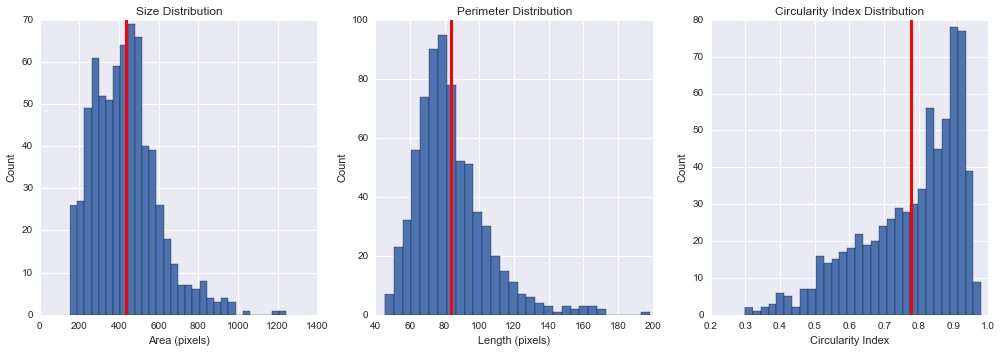

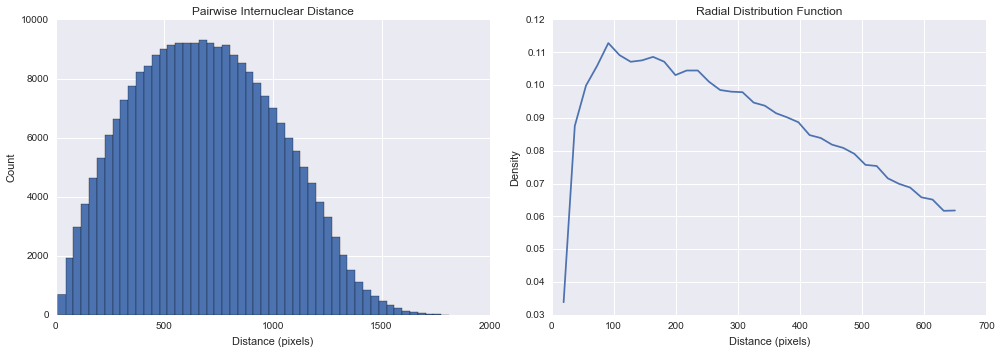

In [37]:
# Some basic stats ?
lab = np.unique(E) # list of different labels
props = measure.regionprops(E)
sizes = np.array([props[i].area for i in range(len(props))])
centroids = np.array([props[i].centroid for i in range(len(props))])
perimeter = np.array([props[i].perimeter for i in range(len(props))])

# Hacky cleanup of segmentation-induced noise
ind = sizes > 150
sizes = sizes[ind]
perimeter = perimeter[ind]
centroids = centroids[ind]

# Pairwise Internuclear Distribution
z = sp.distance.pdist(np.array(centroids)) # Pairwise distances
[g, bins] = np.histogram(z, 100) # Distribution

# Radial Distribution Function
dr = np.mean(np.diff(bins))
V = np.array([np.pi*(2*r*dr + dr**2) for r in bins[1:]]) # Calculate volumes of slices
    
d = bins[1:] - (bins[1] - bins[0])/2. # Distances
d = d[:np.where(d < np.min(E.shape)/2)[0][-1]]
g = g.astype(float) / V # Normalised radial distribution function
g = g[:len(d)] # Truncate at radial limit


plt.subplot(131)
plt.hist(sizes, 30)
plt.axvline(np.mean(sizes), c="r", linewidth=3)
plt.title("Size Distribution")
plt.xlabel("Area (pixels)")
plt.ylabel("Count")

plt.subplot(132)
plt.hist(perimeter, 30)
plt.axvline(np.mean(perimeter), c="r", linewidth=3)
plt.title("Perimeter Distribution")
plt.xlabel("Length (pixels)")
plt.ylabel("Count")

plt.subplot(133)
plt.hist(4 * np.pi * np.array(sizes) / np.array(perimeter)**2, 30)
plt.axvline(np.mean(4 * np.pi * np.array(sizes) / np.array(perimeter)**2), c="r", linewidth=3)
plt.title("Circularity Index Distribution")
plt.xlabel("Circularity Index")
plt.ylabel("Count")

plt.tight_layout()

plt.figure()
plt.subplot(121)
plt.hist(z, 50);
plt.title("Pairwise Internuclear Distance")
plt.xlabel("Distance (pixels)")
plt.ylabel("Count")

plt.subplot(122)
plt.plot(d, g)
plt.title("Radial Distribution Function")
plt.xlabel("Distance (pixels)")
plt.ylabel("Density")

plt.tight_layout()

# PrincetonPy

### princetonpy.com

Join our mailing list, discuss code on the forums, see upcoming sessions